In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# install some requirement libraries
!pip install torch-summary
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.8 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=291653 sha256=5752a193600de41f37b854b56fd7d4902aff80d11aba6cd33d8461c584c5a362
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee


In [6]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import yfinance as yf
import torch.nn as nn
import torch.functional as F
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [7]:
# create a ticker object for Google (GOOGL)
ticker = yf.Ticker("GOOG")

# Define the start and end dates
start_date = "2016-06-14"

# Get historical data for the specified date range
df = ticker.history(start=start_date, end=None)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-14 00:00:00-04:00,35.824001,36.123501,35.655998,35.913502,26122000,0.0,0.0
2016-06-15 00:00:00-04:00,35.950001,36.148998,35.865501,35.945999,24290000,0.0,0.0
2016-06-16 00:00:00-04:00,35.745499,35.832500,35.162998,35.518002,39650000,0.0,0.0
2016-06-17 00:00:00-04:00,35.432499,35.441002,34.422600,34.585999,68048000,0.0,0.0
2016-06-20 00:00:00-04:00,34.938499,35.124001,34.670502,34.685501,41650000,0.0,0.0


In [ ]:
# Create a trace for the candlestick chart
candlestick_trace = go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlestick'
)

# Create the layout
layout = go.Layout(
    title='GOOG Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)

# Create the figure and add the candlestick trace and layout
fig = go.Figure(data=[candlestick_trace], layout=layout)

# Update the layout of the figure
fig.update_layout(xaxis_rangeslider_visible=False)

# Show the figure
fig.show()

In [9]:
# Move column 'Close' to the first position
col_close = df.pop('Close')
df.insert(0, 'Close', col_close)
df.head()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-14 00:00:00-04:00,35.913502,35.824001,36.123501,35.655998,26122000,0.0,0.0
2016-06-15 00:00:00-04:00,35.945999,35.950001,36.148998,35.865501,24290000,0.0,0.0
2016-06-16 00:00:00-04:00,35.518002,35.745499,35.832500,35.162998,39650000,0.0,0.0
2016-06-17 00:00:00-04:00,34.585999,35.432499,35.441002,34.422600,68048000,0.0,0.0
2016-06-20 00:00:00-04:00,34.685501,34.938499,35.124001,34.670502,41650000,0.0,0.0


In [10]:
df.tail()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-22 00:00:00-04:00,151.770004,150.240005,152.559998,150.089996,19226300,0.0,0.0
2024-03-25 00:00:00-04:00,151.149994,150.949997,151.455994,148.800003,15114700,0.0,0.0
2024-03-26 00:00:00-04:00,151.699997,151.240005,153.199997,151.029999,19312700,0.0,0.0
2024-03-27 00:00:00-04:00,151.940002,152.145004,152.690002,150.130005,16622000,0.0,0.0
2024-03-28 00:00:00-04:00,152.259995,152.000000,152.669998,151.330002,21105600,0.0,0.0


In [11]:
df.shape

(1961, 7)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1961 entries, 2016-06-14 00:00:00-04:00 to 2024-03-28 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1961 non-null   float64
 1   Open          1961 non-null   float64
 2   High          1961 non-null   float64
 3   Low           1961 non-null   float64
 4   Volume        1961 non-null   int64  
 5   Dividends     1961 non-null   float64
 6   Stock Splits  1961 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 122.6 KB


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,1961.0,8.355114e+01,3.571367e+01,3.341300e+01,5.370800e+01,7.158600e+01,1.169000e+02,1.548400e+02
Open,1961.0,8.348958e+01,3.570089e+01,3.355000e+01,5.369950e+01,7.152750e+01,1.164900e+02,1.540100e+02
High,1961.0,8.439996e+01,3.611610e+01,3.361500e+01,5.419875e+01,7.209000e+01,1.182250e+02,1.552000e+02
Low,1961.0,8.266228e+01,3.531863e+01,3.316420e+01,5.307600e+01,7.066750e+01,1.151825e+02,1.529200e+02
Volume,1961.0,2.989036e+07,1.323155e+07,6.936000e+06,2.144000e+07,2.647240e+07,3.391000e+07,1.241400e+08
Dividends,1961.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Stock Splits,1961.0,1.019888e-02,4.516388e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01


In [14]:
df.isna().sum().to_frame(name='num_of_NaN')

,num_of_NaN
Close,0
Open,0
High,0
Low,0
Volume,0
Dividends,0
Stock Splits,0


In [15]:
df.duplicated().sum()

0

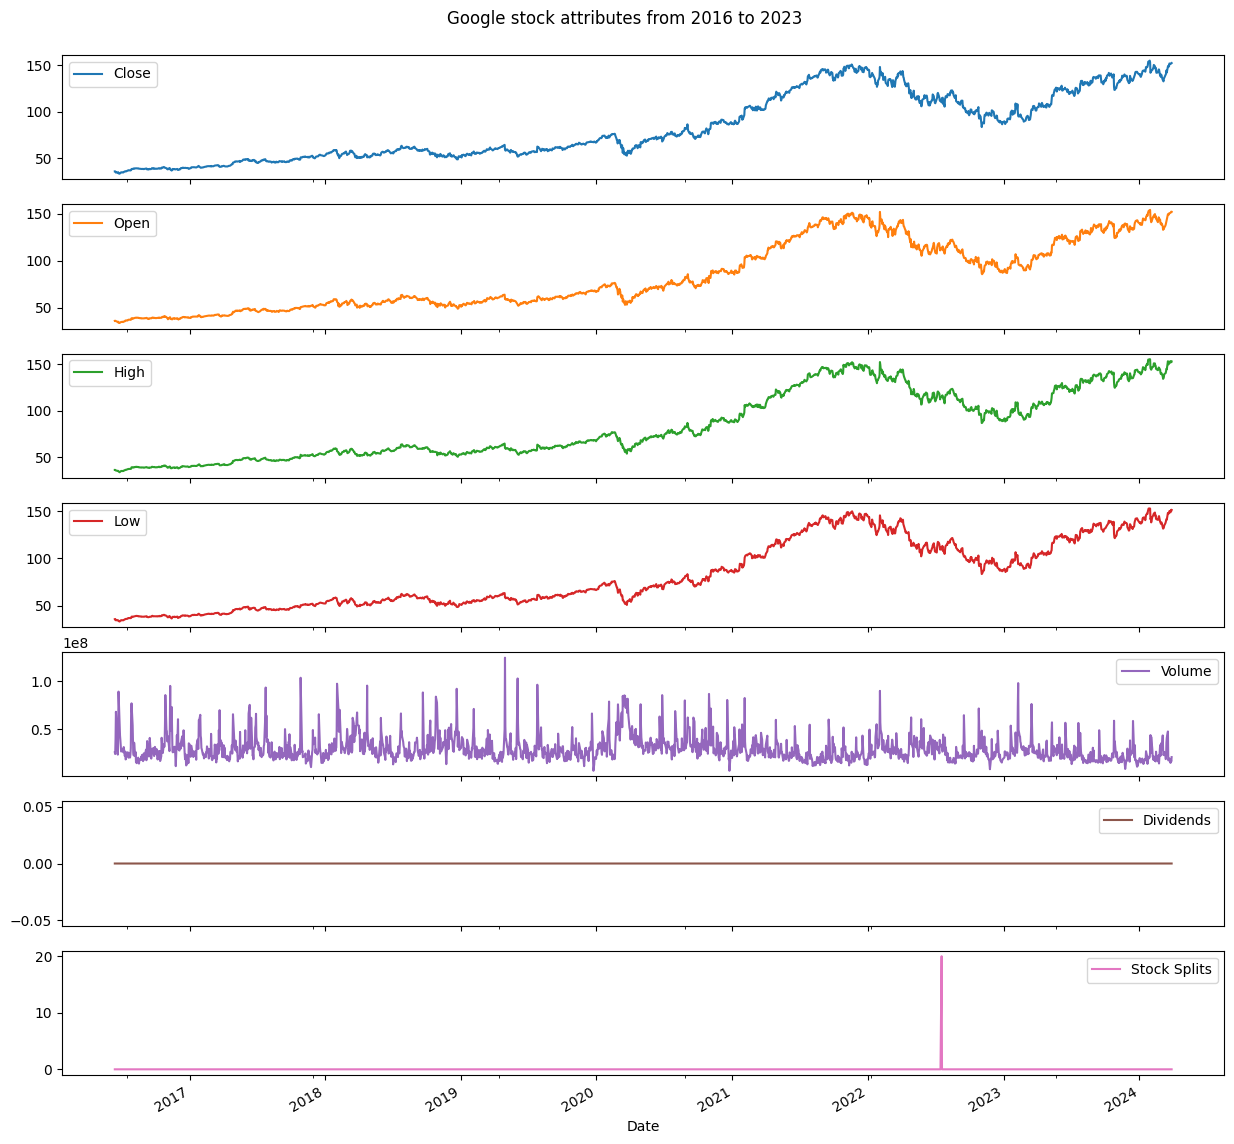

In [17]:
df.plot(subplots=True, figsize=(15, 15))
plt.suptitle('Google stock attributes from 2016 to 2023', y=0.91)
plt.show()

/tmp/ipykernel_33/1413366536.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



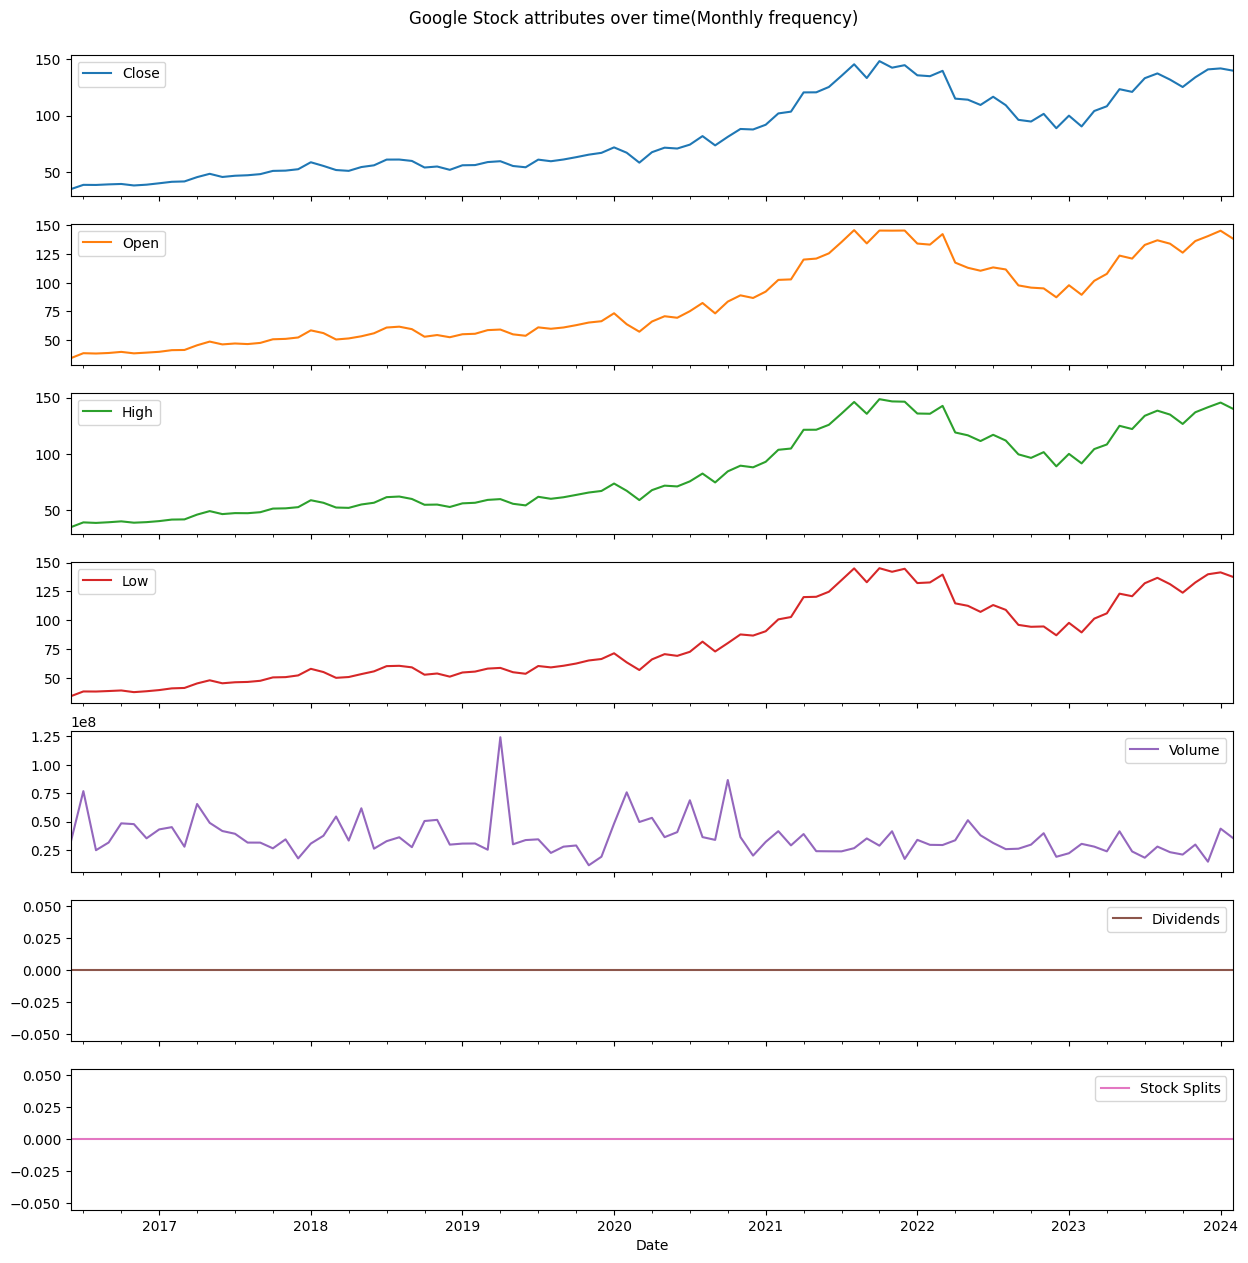

In [18]:
df.asfreq('M', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('Google Stock attributes over time(Monthly frequency)', y=0.91)
plt.show()

In [19]:
df[['Close']]

,Close
Date,
2016-06-14 00:00:00-04:00,35.913502
2016-06-15 00:00:00-04:00,35.945999
2016-06-16 00:00:00-04:00,35.518002
2016-06-17 00:00:00-04:00,34.585999
2016-06-20 00:00:00-04:00,34.685501
...,...
2024-03-22 00:00:00-04:00,151.770004
2024-03-25 00:00:00-04:00,151.149994
2024-03-26 00:00:00-04:00,151.699997


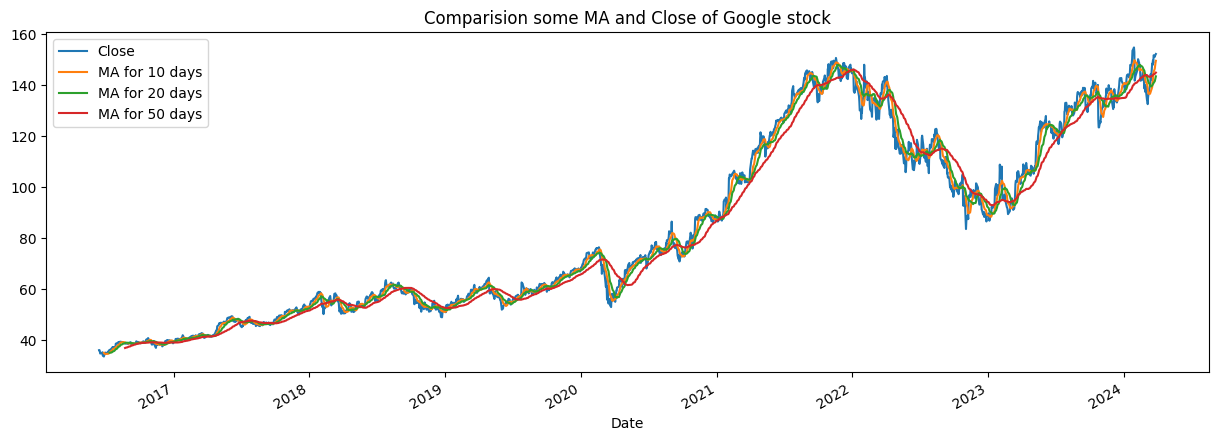

In [20]:
# computing moving average(ma)
ma_day = [10, 20, 50]

for ma in ma_day:
    col_name = f'MA for {ma} days'
    df[col_name] = df['Close'].rolling(ma).mean()

df[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(figsize=(15,5))
plt.title('Comparision some MA and Close of Google stock')
plt.show()

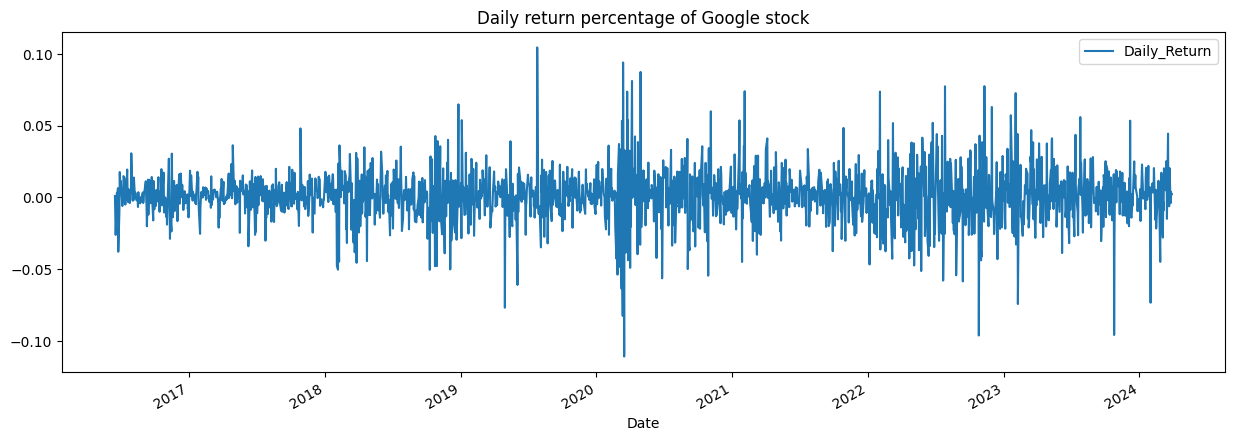

In [21]:
# use pct_change to find the percent change for each day
df['Daily_Return'] = df['Close'].pct_change()
# plot the daily return percentage
df.Daily_Return.plot(legend=True, figsize=(15,5))
plt.title('Daily return percentage of Google stock')
plt.show()

In [22]:
# normalize data
df2 = df.copy(deep=True)
scaler = MinMaxScaler(feature_range=(0,15)).fit(df2.Low.values.reshape(-1,1))
df2['Open'] = scaler.transform(df2.Open.values.reshape(-1,1))
df2['High'] = scaler.transform(df2.High.values.reshape(-1,1))
df2['Low'] = scaler.transform(df2.Low.values.reshape(-1,1))
df2['Close'] = scaler.transform(df2.Close.values.reshape(-1,1))
data = df2[['Open','High','Low', 'Close']].values
data.shape

(1961, 4)

In [23]:
data

array([[ 0.33315316,  0.37066694,  0.31210995,  0.34436352],
       [ 0.3489352 ,  0.37386062,  0.33835125,  0.34843398],
       [ 0.32332031,  0.33421772,  0.25035928,  0.29482519],
       ...,
       [14.78957269, 15.03507122, 14.76326832, 14.84718887],
       [14.90292822, 14.97119191, 14.65053968, 14.87725074],
       [14.88476573, 14.96868628, 14.80084517, 14.91733131]])

In [25]:
seq_len=11
sequences=[]
for index in range(len(data) - seq_len + 1): 
    sequences.append(data[index: index + seq_len])
sequences= np.array(sequences)

In [27]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

valid_set_size = int(np.round(valid_set_size_percentage/100*sequences.shape[0]))  
test_set_size  = int(np.round(test_set_size_percentage/100*sequences.shape[0]))
train_set_size = sequences.shape[0] - (valid_set_size + test_set_size)

x_train = sequences[:train_set_size,:-1,:]
y_train = sequences[:train_set_size,-1,:]
    
x_valid = sequences[train_set_size:train_set_size+valid_set_size,:-1,:]
y_valid = sequences[train_set_size:train_set_size+valid_set_size,-1,:]
    
x_test = sequences[train_set_size+valid_set_size:,:-1,:]
y_test = sequences[train_set_size+valid_set_size:,-1,:]

In [29]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

train_dataset = TensorDataset(x_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

valid_dataset = TensorDataset(x_valid,y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

/tmp/ipykernel_33/372158831.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_33/372158831.py:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_33/372158831.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_33/372158831.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [31]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self, num_feature):
        super(NeuralNetwork, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = NeuralNetwork(4)

#push to cuda if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
# model = model.to(device)

In [32]:
# print summary of model like summary in tensorflow
summary(model, (4, ))

Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 64]                  17,920
├─Linear: 1-2                            [-1, 4]                   260
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07


Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 64]                  17,920
├─Linear: 1-2                            [-1, 4]                   260
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07

In [33]:
optimizer = optim.Adam(model.parameters())
mse = nn.MSELoss()

In [34]:
def train(dataloader):
    epoch_loss = 0
    model.train()  
    
    for batch in dataloader:
        optimizer.zero_grad()          
        x,y= batch
        pred = model(x)
        loss = mse(pred[0],y)        
        loss.backward()               
        optimizer.step()      
        epoch_loss += loss.item()  
        
    return epoch_loss

In [36]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()  
    
    with torch.no_grad():
      for batch in dataloader:   
          x,y= batch
          pred = model(x)
          loss = mse(pred[0],y)              
          epoch_loss += loss.item()  
        
    return epoch_loss / len(dataloader)

In [37]:
n_epochs = 50
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):

    train_loss = train(train_dataloader)
    valid_loss = evaluate(valid_dataloader)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, 'saved_weights.pt')

    # print("Epoch ",epoch+1)
    print(f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

	Train Loss: 965.87060 | 	Val Loss: 21.09042

	Train Loss: 839.94175 | 	Val Loss: 15.57377

	Train Loss: 488.85676 | 	Val Loss: 8.15244

	Train Loss: 321.36456 | 	Val Loss: 4.46519

	Train Loss: 200.62544 | 	Val Loss: 2.41491

	Train Loss: 130.10850 | 	Val Loss: 1.22402

	Train Loss: 89.80438 | 	Val Loss: 0.83145

	Train Loss: 64.02528 | 	Val Loss: 2.21819

	Train Loss: 47.03885 | 	Val Loss: 0.32643

	Train Loss: 37.01210 | 	Val Loss: 2.10371

	Train Loss: 56.31582 | 	Val Loss: 1.38739

	Train Loss: 42.56531 | 	Val Loss: 0.27179

	Train Loss: 35.88709 | 	Val Loss: 0.72127

	Train Loss: 45.59458 | 	Val Loss: 5.29794

	Train Loss: 28.38720 | 	Val Loss: 0.19872

	Train Loss: 53.31867 | 	Val Loss: 4.85432

	Train Loss: 24.83506 | 	Val Loss: 0.33058

	Train Loss: 26.39431 | 	Val Loss: 0.52581

	Train Loss: 28.46118 | 	Val Loss: 0.41046

	Train Loss: 48.89136 | 	Val Loss: 0.27015

	Train Loss: 35.98215 | 	Val Loss: 0.21380

	Train Loss: 13.86930 | 	Val Loss: 1.88766

	Train Loss: 15.84384 | 

In [38]:
model=torch.load('saved_weights.pt')

In [39]:
x_test= torch.tensor(x_test).float()

with torch.no_grad():
  y_test_pred = model(x_test)

y_test_pred = y_test_pred.numpy()[0]

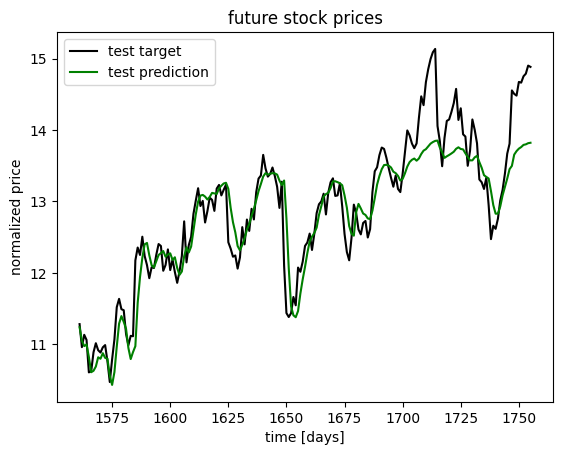

In [40]:
idx=0
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,idx], color='black', label='test target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,idx], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')

In [41]:
index_values = df[len(df) - len(y_test):].index
col_values = ['Open', 'Low', 'High', 'Close']
df_results = pd.DataFrame(data=y_test_pred, index=index_values, columns=col_values)

In [42]:
# Create a trace for the candlestick chart
candlestick_trace = go.Candlestick(
    x=df_results.index,
    open=df_results['Open'],
    high=df_results['High'],
    low=df_results['Low'],
    close=df_results['Close'],
    name='Candlestick'
)

# Create the layout
layout = go.Layout(
    title='GOOG Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)

# Create the figure and add the candlestick trace and layout
fig = go.Figure(data=[candlestick_trace], layout=layout)

# Update the layout of the figure
fig.update_layout(xaxis_rangeslider_visible=False)

# Show the figure
fig.show()

In [46]:
# Get the last sequence of historical data as features for predicting the next 10 days
last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()

# Generate predictions for the next 10 days
PRED_DAYS = 10
with torch.no_grad():
    for i in range(PRED_DAYS):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]


pred_days = last_sequence.reshape(PRED_DAYS, 4).numpy()

# inverse transform the predicted values
pred_days = scaler.inverse_transform(pred_days)

df_pred = pd.DataFrame(
    data=pred_days,
    columns=['Open', 'High', 'Low', 'Close']
)

df_pred

,Open,High,Low,Close
0,143.569107,145.122482,141.634415,142.922333
1,142.824249,144.400345,141.068771,142.295258
2,142.237350,143.775940,140.553696,141.774414
3,141.753799,143.270096,140.114334,141.327118
4,141.359467,142.864395,139.748138,140.953171
5,141.040665,142.539642,139.448257,140.646591
6,140.784561,142.280121,139.205536,140.398422
7,140.582138,142.075378,139.013077,140.201736
8,140.425766,141.917297,138.864532,140.050003
9,140.306793,141.796616,138.751709,139.934784
